# ***CREDIT DATA ANALYSIS*: ANÁLISE EXPLORATÓRIA DE DADOS DE CRÉDITO**

<p style='justify'>Este é um trabalho do curso de analista de dados da EBAC, do bloco sobre SQL. Seu intuito é realizar uma análise exploratória de informações demográficas e financeiras de clientes de um banco.

<p style='justify'>Para tanto, será utilizada a linguagem SQLite, via módulo pandasql no próprio Python bem como recursos gráficos da linguagem.

## 1. Instalando, carregando módulos e extraindo o *dataset*

O pacote `pandasql` interpreta `DataFrames`, faz a consulta via SQL e retorna com um `DataFrame`.

In [321]:
!pip install pandasql
!pip install SQLAlchemy==1.4.46

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [322]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pandasql import sqldf
import seaborn as sns

In [323]:
!git clone 'https://github.com/vihmalmsteen/Kaggle.git' 'githut'
credito = pd.read_excel('/content/githut/datasets/credito.xlsx', index_col=False)

fatal: destination path 'githut' already exists and is not an empty directory.


Composição do dataset:

<center>

| COLUNA               | TIPO   | DESCRICAO                                              |
| -------------------- | ------ | ------------------------------------------------------ |
| idade                | INT    | idade do cliente                                       |
| sexo                 | STRING | sexo do cliente (F ou M)                               |
| dependentes          | INT    | número de dependentes do cliente                       |
| escolaridade         | STRING | nível de escolaridade do cliente                       |
| estado_civil         | STRING | estado conjugal, de matrimônio ou à sociedade conjugal |
| salario_anual        | STRING | faixa salarial do cliente                              |
| tipo_cartao          | STRING | tipo de cartao do cliente                              |
| qtd_produtos         | BIGINT | quantidade de produtos comprados nos últimos 12 meses  |
| iteracoes_12m        | INT    | quantidade de transacoes nos ultimos 12 meses          |
| meses_inativo_12m    | INT    | quantidade de meses que o cliente ficou inativo        |
| limite_credito       | FLOAT  | limite de credito do cliente                           |
| valor_transacoes_12m | FLOAT  | valor das transações dos ultimos 12 meses              |
| qtd_transacoes_12m   | INT    | quantidade de transacoes dos ultimos 12 meses          |

</center>

## 2. Qualidade dos dados

In [324]:
credito.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   idade                 2564 non-null   int64  
 1   sexo                  2564 non-null   object 
 2   dependentes           2564 non-null   int64  
 3   escolaridade          2564 non-null   object 
 4   estado_civil          2564 non-null   object 
 5   salario_anual         2564 non-null   object 
 6   tipo_cartao           2564 non-null   object 
 7   qtd_produtos          2564 non-null   int64  
 8   iteracoes_12m         2564 non-null   int64  
 9   meses_inativo_12m     2564 non-null   int64  
 10  limite_credito        2564 non-null   float64
 11  valor_transacoes_12m  2564 non-null   float64
 12  qtd_transacoes_12m    2564 non-null   int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 260.5+ KB


<p align='justify'>A princípio, não há ausência de dados. Contudo, por vezes informações nulas podem estar "mascaradas" como textos. Observando, por exemplo, algumas das colunas do tipo object (basicamente, textuais) há a presença de registros 'na' (dados ausentes).

In [325]:
# dados ausentes em 'escolaridade'
sqldf('''select distinct escolaridade from credito''')

,escolaridade
0,ensino medio
1,mestrado
2,sem educacao formal
3,na
4,graduacao
5,doutorado


<p align='justify'>Vejamos quantos dados teriamos eliminando os registros 'na':

In [326]:
sqldf('''
select
  'registros (+NA)' as 'nº de registros'
, count(*) as total
from credito

   union all

select
  'pelo menos um com na' as 'nº de registros'
, count(*) as total
from credito
where escolaridade = 'na' or estado_civil = 'na' or salario_anual = 'na'

   union all

select
  'registros (noNA)' as 'nº de registros'
, count(*) as total
from credito
where escolaridade <> 'na' and estado_civil <> 'na' and salario_anual <> 'na'
''')

,nº de registros,total
0,registros (+NA),2564
1,pelo menos um com na,638
2,registros (noNA),1926


<p align='justify'>Considerando que uma ou múltiplas colunas podem ter registros nulos, removendo via query estes registros, restariam pouco menos de 2.000. O ideal seria buscar estas informações e não trabalhar com 638 registros a menos. Entretanto, removamos estas linhas.

In [327]:
credito = sqldf('''
select * from credito
where escolaridade <> 'na' and estado_civil <> 'na' and salario_anual <> 'na'
''')

In [328]:
sqldf('''select * from credito limit 5''')

,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,45,M,3,ensino medio,casado,$60K - $80K,blue,5,3,1,12691.51,1144.90,42
1,49,F,5,mestrado,solteiro,menos que $40K,blue,6,2,1,8256.96,1291.45,33
2,51,M,3,mestrado,casado,$80K - $120K,blue,4,0,1,3418.56,1887.72,20
3,40,M,3,sem educacao formal,casado,$60K - $80K,blue,5,0,1,4716.22,816.08,28
4,44,M,2,mestrado,casado,$40K - $60K,blue,3,2,1,4010.69,1088.07,24


## 3. Análise demográfica

<p align='justify'>Dos dados remanescentes, vejamos um pouco qual o perfil dos clientes. Das informações presentes, temos:</p>

*  sexo
*  idade
*  dependentes
*  escolaridade
*  estado_civil
*  salario_anual

### 3.1. Sexo

In [329]:
# GÊNERO:
Q1 = sqldf('''
select sexo, count(*) as total 
from credito 
group by sexo
''')
Q1

,sexo,total
0,F,669
1,M,1257


O número de clientes homens é quase o dobro do número de clientes mulheres.

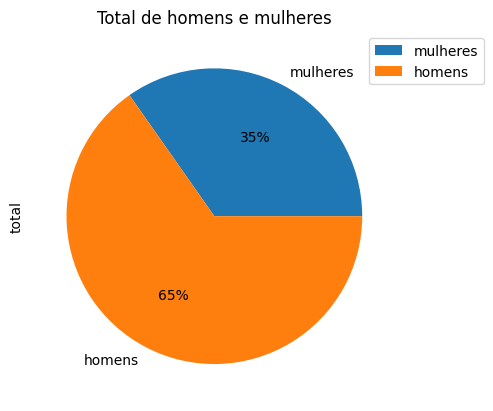

In [330]:
ax = Q1.plot.pie(y="total",
            title='Total de homens e mulheres',
            labels=['mulheres','homens'], 
            autopct='%.0f%%');
ax.legend(bbox_to_anchor=(0.9, 1), loc='upper left');

### 3.2. Salário anual

In [331]:
Q2 = sqldf('''
select 
  salario_anual
, count(*) as total
from credito 
group by salario_anual 
Order by case when salario_anual = 'menos que $40K' then 1
              when salario_anual = '$40K - $60K'    then 2
              when salario_anual = '$60K - $80K'    then 3
              when salario_anual = '$80K - $120K'   then 4
              else 5 end
''')
Q2

,salario_anual,total
0,menos que $40K,597
1,$40K - $60K,385
2,$60K - $80K,363
3,$80K - $120K,400
4,$120K +,181


O perfil dos clientes segue uma proporção social comum. Há mais clientes que ganham menos em comparação ao grupo que ganha mais. As 3 faixas salariais medianas seguem "de lado" ou na mesma medida, enquanto pessoas com a menor faixa salarial são o maior contingente de clientes e os mais abastados são a menor parcela.

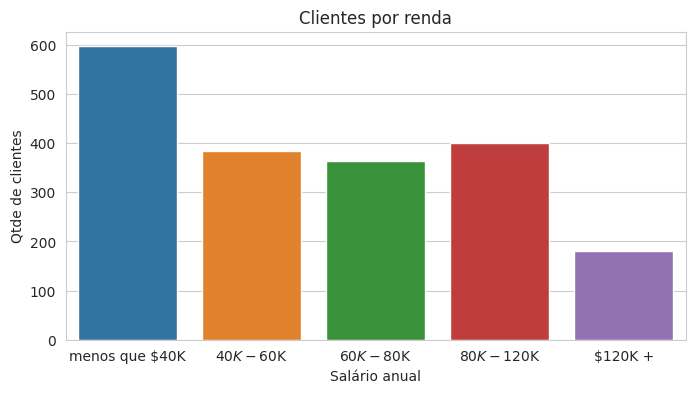

In [332]:
with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(figsize=(8,4))
  sns.barplot(Q2, x='salario_anual', y='total')
  ax.set_title('Clientes por renda')
  ax.set_xlabel('Salário anual')
  ax.set_ylabel('Qtde de clientes');

### 3.3. Sexo e salário anual

In [333]:
Q3 = sqldf('''
select 
  salario_anual
, sexo
, count(*) as total
from credito 
group by salario_anual, sexo
Order by case when salario_anual = 'menos que $40K' then 1
              when salario_anual = '$40K - $60K'    then 2
              when salario_anual = '$60K - $80K'    then 3
              when salario_anual = '$80K - $120K'   then 4
              else 5 end
         , sexo
''')
Q3

,salario_anual,sexo,total
0,menos que $40K,F,508
1,menos que $40K,M,89
2,$40K - $60K,F,161
3,$40K - $60K,M,224
4,$60K - $80K,M,363
5,$80K - $120K,M,400
6,$120K +,M,181


<p align='justify'>Com os dados presentes, pode-se ver os clientes que são mulheres têm uma renda bastante inferior aos clientes homens. 

<p align='justify'>Não há clientes do sexo feminino cuja renda anual seja superior a $60.000$, sendo muito mais ampla a quantidade deste grupo na faixa de até $40.000$. Já homens parecem ter sua renda anual se distribuindo normalmente com uma média de $80.000$ aproximadamente, tendo salários bem superiores.

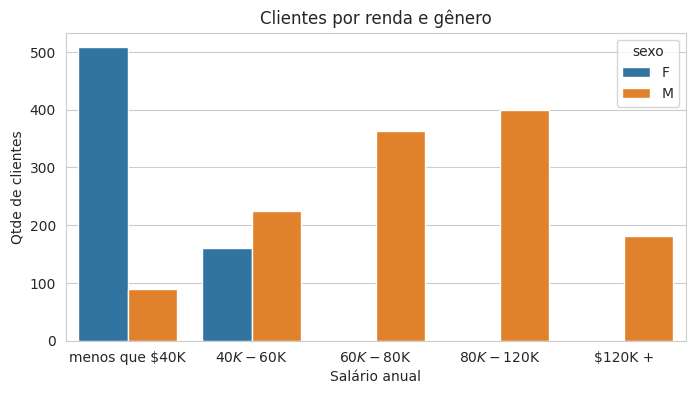

In [334]:
with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(figsize=(8,4))
  sns.barplot(Q3, x='salario_anual',y='total', hue='sexo')
  ax.set_title('Clientes por renda e gênero')
  ax.set_xlabel('Salário anual')
  ax.set_ylabel('Qtde de clientes');

### 3.4. Sexo e faixa etária

In [335]:
Q4 = sqldf('''
select 
  c.sexo
, case when c.idade between  0 and  9 then  '0 ~ 9'
       when c.idade between 10 and 19 then '10 ~ 19'
       when c.idade between 20 and 29 then '20 ~ 29'
       when c.idade between 30 and 39 then '30 ~ 39'
       when c.idade between 40 and 49 then '40 ~ 49'
       when c.idade between 50 and 59 then '50 ~ 59'
       when c.idade between 60 and 69 then '60 ~ 69'
       when c.idade between 70 and 79 then '70 ~ 79'
       when c.idade >= 80 then '80+'
       end as faixa_etaria
, count(*) as total 
from credito c
group by sexo, faixa_etaria
order by faixa_etaria, sexo
''')
Q4

,sexo,faixa_etaria,total
0,F,20 ~ 29,23
1,M,20 ~ 29,52
2,F,30 ~ 39,181
3,M,30 ~ 39,366
4,F,40 ~ 49,181
5,M,40 ~ 49,354
6,F,50 ~ 59,212
7,M,50 ~ 59,402
8,F,60 ~ 69,72
9,M,60 ~ 69,81


Tanto homens como mulheres se distribuem de maneira semelhante e de forma normal quando o assunto é faixa etária. Não há nada muito relevante neste conjunto.

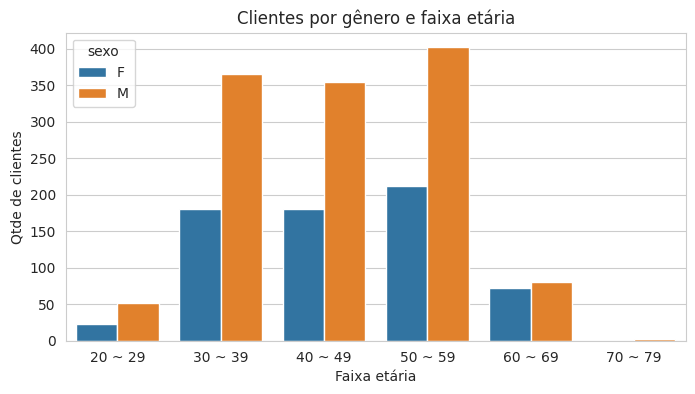

In [336]:
with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(figsize=(8,4))
  sns.barplot(data=Q4, x='faixa_etaria', y='total', hue='sexo');
  ax.set_xlabel('Faixa etária')
  ax.set_ylabel('Qtde de clientes')
  ax.set_title('Clientes por gênero e faixa etária');

### 3.5. Escolaridade

In [337]:
Q5 = sqldf('''
select 
  escolaridade
, count(*) as total
from credito 
group by escolaridade 
order by case when escolaridade = 'sem educacao formal' then 1
              when escolaridade = 'ensino medio' then 2
              when escolaridade = 'graduacao' then 3
              when escolaridade = 'mestrado' then 4
              else 5 end
''')
Q5

,escolaridade,total
0,sem educacao formal,319
1,ensino medio,471
2,graduacao,230
3,mestrado,707
4,doutorado,199


<p align='justify'>Era esperado que a distribuição seguisse a ordem de escolaridade. Ou seja, mais pessoas sem uma educação formal e decrescendo até o nível de doutor. Ou, pelo menos, uma concentração maior de pessoas que tenham graduação, e reduzindo até as caudas.

<p align='justify'>Mas, clientes mestres se destacam, seguidos por clientes com ensino médio. Boa parte dos clientes tem um bom nível educacional: pelo menos graduação (1.136) VS até ensino médio (790).

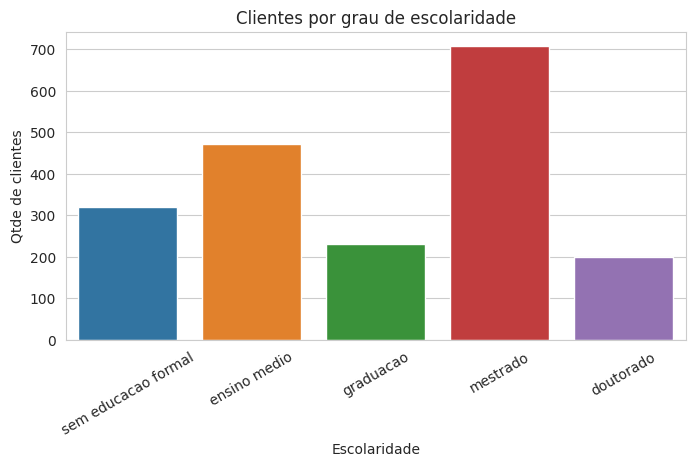

In [338]:
with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(figsize=(8,4))
  sns.barplot(Q5, x='escolaridade', y='total')
  ax.set_title('Clientes por grau de escolaridade')
  ax.set_xlabel('Escolaridade')
  ax.set_ylabel('Qtde de clientes')
  plt.xticks(rotation=30);

### 3.6. Escolaridade e sexo

In [339]:
sqldf('''
select 
M.escolaridade, M.total as homens, F.total as mulheres
from 
(select 
    escolaridade
  , count(*) as total
  from credito 
  where sexo = 'M'
  group by escolaridade
) as M

inner join

(select 
    escolaridade
  , count(*) as total
  from credito 
  where sexo = 'F'
  group by escolaridade
) as F

on M.escolaridade = F.escolaridade

order by case when M.escolaridade = 'sem educacao formal' then 1
              when M.escolaridade = 'ensino medio' then 2
              when M.escolaridade = 'graduacao' then 3
              when M.escolaridade = 'mestrado' then 4
              else 5 end
''')

,escolaridade,homens,mulheres
0,sem educacao formal,197,122
1,ensino medio,326,145
2,graduacao,152,78
3,mestrado,454,253
4,doutorado,128,71


<p align='justify'>Curiosamente, mesmo que a quantidade de clientes mulheres seja menor, elas recebem menos apesar de ter proporcionalmente uma formação parecida com a dos clientes homens.

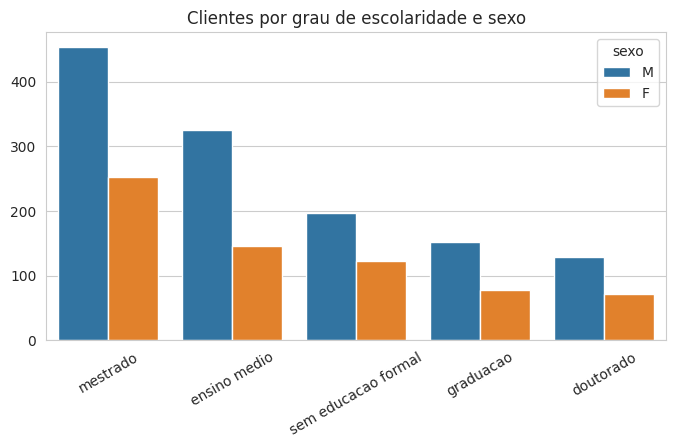

In [340]:
Q6 = sqldf('''
select escolaridade, sexo, count(*) as total
from credito 
group by escolaridade, sexo
order by total desc
''')

with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(figsize=(8,4))
  sns.barplot(Q6, x='escolaridade', y='total', hue='sexo')
  ax.set_title('Clientes por grau de escolaridade e sexo')
  ax.set_xlabel('')
  ax.set_ylabel('')
  plt.xticks(rotation=30);

### 3.7. Salário, escolaridade e sexo

In [341]:
sqldf('''

select M.salario_anual, M.faixa_escolar, M.total as homens, ifnull(F.total, 0) as mulheres
from 
(
  select 
    case when escolaridade in ('sem educacao formal', 'ensino medio') then 'baixa escolaridade' 
         else 'alta escolaridade' end as faixa_escolar
  , salario_anual
  , count(*) as total
  from credito 
  where sexo = 'M'
  group by faixa_escolar, salario_anual
) as M

left join

(
  select 
    case when escolaridade in ('sem educacao formal', 'ensino medio') then 'baixa escolaridade' 
         else 'alta escolaridade' end as faixa_escolar
  , salario_anual
  , count(*) as total
  from credito 
  where sexo = 'F'
  group by faixa_escolar, salario_anual
) as F

on M.faixa_escolar || '_' || M.salario_anual = F.faixa_escolar || '_' || F.salario_anual

order by case when M.salario_anual = 'menos que $40K' then 1
              when M.salario_anual = '$40K - $60K'    then 2
              when M.salario_anual = '$60K - $80K'    then 3
              when M.salario_anual = '$80K - $120K'   then 4
              else 5 end,
         case when M.faixa_escolar = 'baixa escolaridade' then 1
              else 2 end

''')

,salario_anual,faixa_escolar,homens,mulheres
0,menos que $40K,baixa escolaridade,36,198
1,menos que $40K,alta escolaridade,53,310
2,$40K - $60K,baixa escolaridade,105,69
3,$40K - $60K,alta escolaridade,119,92
4,$60K - $80K,baixa escolaridade,153,0
5,$60K - $80K,alta escolaridade,210,0
6,$80K - $120K,baixa escolaridade,155,0
7,$80K - $120K,alta escolaridade,245,0
8,$120K +,baixa escolaridade,74,0
9,$120K +,alta escolaridade,107,0


<p align='justify'>Chama atenção a quantidade de mulheres com um bom nível escolar (pelo menos com graduação) que ganham menos de $40.000$, sendo 310 contra 53 homens. Ou seja, apesar do nível educacional ser distruibuído da mesma maneira enter homens e mulheres, elas ganham (bem) menos que os clientes homens.

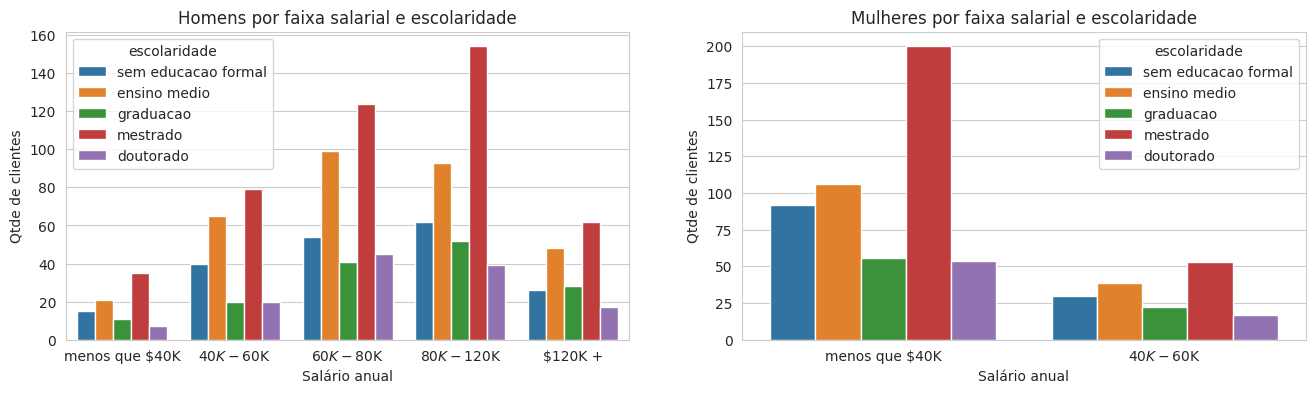

In [342]:
Q7 = sqldf('''
select escolaridade, sexo, salario_anual, count(*) as total
from credito 
group by escolaridade, sexo, salario_anual
order by sexo, 
         case when escolaridade = 'sem educacao formal' then 1
              when escolaridade = 'ensino medio' then 2
              when escolaridade = 'graduacao' then 3
              when escolaridade = 'mestrado' then 4
              else 5 end,
         case when salario_anual = 'menos que $40K' then 1
              when salario_anual = '$40K - $60K'  then 2
              when salario_anual = '$60K - $80K'  then 3
              when salario_anual = '$80K - $120K' then 4
              else 5 end
''')

with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(1, 2, figsize=(8*2,4))

  sns.barplot(Q7.query('sexo=="M"'), x='salario_anual', y='total',hue='escolaridade', ax=ax[0])
  ax[0].set_title('Homens por faixa salarial e escolaridade')
  ax[0].set_xlabel('Salário anual')
  ax[0].set_ylabel('Qtde de clientes')

  sns.barplot(Q7.query('sexo=="F"'), x='salario_anual', y='total',hue='escolaridade', ax=ax[1])
  ax[1].set_title('Mulheres por faixa salarial e escolaridade')
  ax[1].set_xlabel('Salário anual')
  ax[1].set_ylabel('Qtde de clientes');

### 3.8. Dependentes

In [343]:
Q8 = sqldf('''select dependentes, count(*) as total from credito group by dependentes''')
Q8

,dependentes,total
0,0,252
1,1,409
2,2,523
3,3,466
4,4,233
5,5,43


Os clientes têm de 0 a 5 dependentes, em que a maior parte dos clientes tem 2 dependentes.

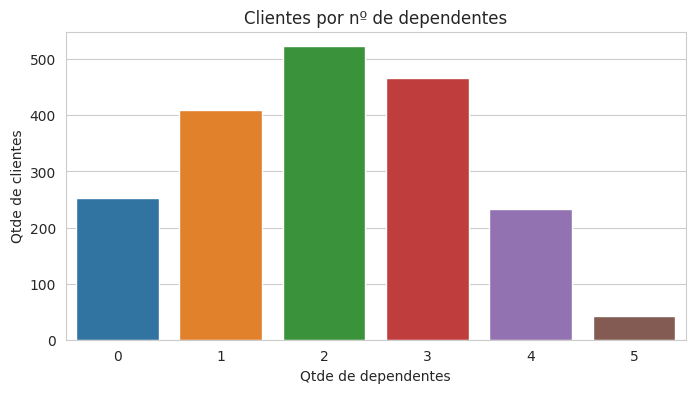

In [344]:
with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(figsize=(8,4))

  sns.barplot(Q8, x='dependentes', y='total')
  ax.set_title('Clientes por nº de dependentes')
  ax.set_xlabel('Qtde de dependentes')
  ax.set_ylabel('Qtde de clientes');

### 3.9. Dependentes e sexo

In [345]:
Q9 = sqldf('''
select 
  sexo
, round(avg(dependentes),1) as media
from credito
group by sexo
''')
Q9

,sexo,media
0,F,2.0
1,M,2.1


In [346]:
sqldf('''

select M.dependentes, M.total as homens, F.total as mulheres
from
(
select dependentes, count(*) as total
from credito
where sexo = 'M'
group by dependentes
) as M

inner join

(
select dependentes, count(*) as total
from credito
where sexo = 'F'
group by dependentes
) as F

on M.dependentes = F.dependentes
''')

,dependentes,homens,mulheres
0,0,155,97
1,1,265,144
2,2,341,182
3,3,324,142
4,4,145,88
5,5,27,16


Homens e mulheres têm uma média virtualmente idêntica de dependentes. 

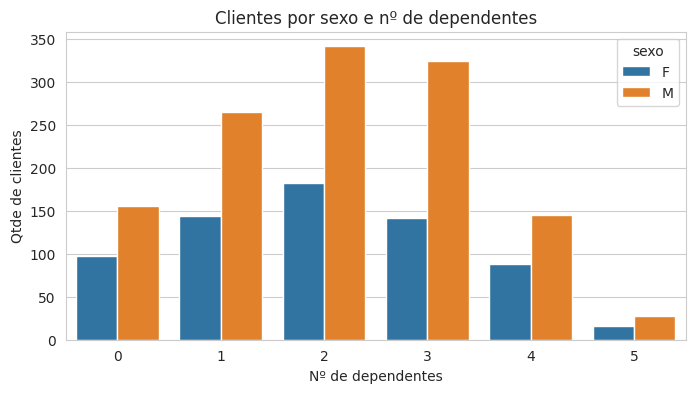

In [347]:
Q10 = sqldf('''
select 
  sexo, dependentes, count(*) as total
from credito
group by sexo, dependentes
''')

with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(figsize=(8,4))

  sns.barplot(Q10, x='dependentes', y='total',hue='sexo')
  ax.set_title('Clientes por sexo e nº de dependentes')
  ax.set_xlabel('Nº de dependentes')
  ax.set_ylabel('Qtde de clientes');

### 3.10. Dependentes por renda anual

In [348]:
sqldf('''
select dep_0.salario_anual, dep_0.zero_dep, dep_1.um_dep, dep_2.dois_dep
     , dep_3.tres_dep, dep_4.quatro_dep, dep_5.cinco_dep 
from

(select dependentes, salario_anual, count(*) as zero_dep
 from credito where dependentes = 0 group by salario_anual, dependentes) dep_0

inner join

(select dependentes, salario_anual, count(*) as um_dep
 from credito where dependentes = 1 group by salario_anual, dependentes) dep_1

on dep_0.salario_anual = dep_1.salario_anual
inner join

(select dependentes, salario_anual, count(*) as dois_dep
 from credito where dependentes = 2 group by salario_anual, dependentes) dep_2

on dep_0.salario_anual = dep_2.salario_anual
inner join

(select dependentes, salario_anual, count(*) as tres_dep
 from credito where dependentes = 3 group by salario_anual, dependentes) dep_3

on dep_0.salario_anual = dep_3.salario_anual
inner join

(select dependentes, salario_anual, count(*) as quatro_dep
 from credito where dependentes = 4 group by salario_anual, dependentes) dep_4

on dep_0.salario_anual = dep_4.salario_anual
inner join

(select dependentes, salario_anual, count(*) as cinco_dep
 from credito where dependentes = 5 group by salario_anual, dependentes) dep_5

on dep_0.salario_anual = dep_5.salario_anual

order by case when dep_0.salario_anual = 'menos que $40K' then 1
              when dep_0.salario_anual = '$40K - $60K'    then 2
              when dep_0.salario_anual = '$60K - $80K'    then 3
              when dep_0.salario_anual = '$80K - $120K'   then 4
              else 5 end
''')

,salario_anual,zero_dep,um_dep,dois_dep,tres_dep,quatro_dep,cinco_dep
0,menos que $40K,114,123,162,114,72,12
1,$40K - $60K,68,93,97,83,35,9
2,$60K - $80K,35,75,100,98,46,9
3,$80K - $120K,25,90,103,119,56,7
4,$120K +,10,28,61,52,24,6


In [349]:
sqldf('''
select
  salario_anual
, round(avg(dependentes),1) as avg_dependentes
from credito
group by salario_anual
order by case when salario_anual = 'menos que $40K' then 1
              when salario_anual = '$40K - $60K'    then 2
              when salario_anual = '$60K - $80K'    then 3
              when salario_anual = '$80K - $120K'   then 4
              else 5 end
''')

,salario_anual,avg_dependentes
0,menos que $40K,1.9
1,$40K - $60K,1.9
2,$60K - $80K,2.2
3,$80K - $120K,2.3
4,$120K +,2.4


<p align='justify'>O nº de dependentes se distribui quase normalmente entre os grupos de faixa de renda. Em termos médios, para quanto maior a renda, a tendência é ter mais dependentes.

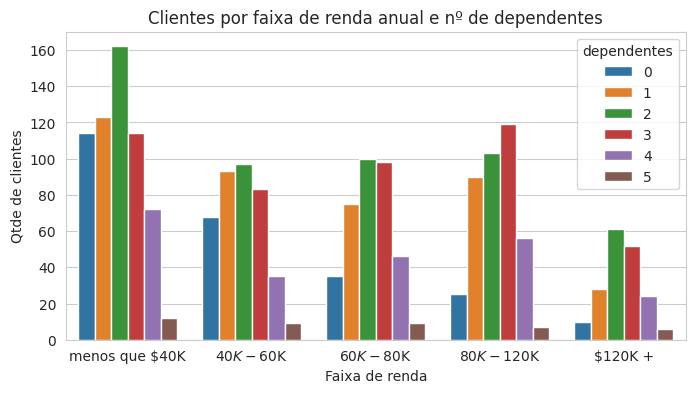

In [350]:
Q11 = sqldf('''
select
  dependentes
, salario_anual
, count(*) as total
from credito
group by salario_anual, dependentes
order by dependentes
       , case when salario_anual = 'menos que $40K' then 1
              when salario_anual = '$40K - $60K'    then 2
              when salario_anual = '$60K - $80K'    then 3
              when salario_anual = '$80K - $120K'   then 4
              else 5 end
''')

with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(figsize=(8,4))

  sns.barplot(Q11, x='salario_anual', y='total', hue='dependentes')
  ax.set_title('Clientes por faixa de renda anual e nº de dependentes')
  ax.set_xlabel('Faixa de renda')
  ax.set_ylabel('Qtde de clientes');

## 4. Análise bancária/comercial

Dos dados referentes ao lado do banco a serem analisadas, tem-se os seguintes:

*  tipo_cartao
*  qtd_produtos
*  limite_credito
*  valor_transacoes_12m
*  qtd_transacoes_12m

### 4.1. Métricas de volume financeiro e de produtos transacionados dos clientes

In [351]:
Q12 = sqldf('''
select
  salario_anual
, count(salario_anual)                 as qtd_clientes
, round(sum(valor_transacoes_12m),2)   as total_transacao
, round(sum(qtd_produtos),0)           as total_produtos
, round(avg(valor_transacoes_12m),2)   as avg_transacao
, round(avg(qtd_produtos),1)           as avg_produtos
, round(sum(valor_transacoes_12m) / sum(qtd_produtos),2) as 'preco/produto'
from credito
group by salario_anual
order by case when salario_anual = 'menos que $40K' then 1
              when salario_anual = '$40K - $60K'    then 2
              when salario_anual = '$60K - $80K'    then 3
              when salario_anual = '$80K - $120K'   then 4
              else '$120K +' end
''')
Q12

,salario_anual,qtd_clientes,total_transacao,total_produtos,avg_transacao,avg_produtos,preco/produto
0,menos que $40K,597,1108040.28,2618.0,1856.01,4.4,423.24
1,$40K - $60K,385,708775.24,1675.0,1840.97,4.4,423.15
2,$60K - $80K,363,656002.23,1578.0,1807.17,4.3,415.72
3,$80K - $120K,400,712033.78,1717.0,1780.08,4.3,414.70
4,$120K +,181,308978.32,769.0,1707.06,4.2,401.79


<p align="justify">Quanto menor a renda mais se compra em volume de produtos anualmente. Quem recebe até $40.000$, por exemplo, compra em média 1.000 produtos a mais que pessoas que recebem entre $40.000$ e $60.000$ (2º grupo que mais compra).

<p align="justify">Quanto ao volume monetário transacionado, a diferença é bem mais sutíl, mas existe. Pessoas com renda menor gastam, em média, mais.

<p align='justify'>Além disso, pessoas com renda menor tendem a gastar mais por produto. Haja vista a razão entre o total financeiro transacionado e o total de produtos comprados (preco/produto). Como não se tem a cesta de produtos, não se pode dizer muito sobre qual produto é ou não mais caro.

<p align="justify">Pelo volume de clientes com menor renda ser expressivo (menos de 40K/ano), o total transacionado e volume de itens comprados se descola - principalmente se comparando com os clientes com o maior nível de renda.

In [352]:
Q13a = sqldf('''
select
  sexo
, count(salario_anual)                 as qtd_clientes
, round(sum(valor_transacoes_12m),2)   as total_transacao
, round(sum(qtd_produtos),0)           as total_produtos
, round(avg(valor_transacoes_12m),2)   as avg_transacao
, round(avg(qtd_produtos),1)           as avg_produtos
, round(sum(valor_transacoes_12m) / sum(qtd_produtos),2) as 'preco/produto'
from credito
group by sexo
order by sexo, case when salario_anual = 'menos que $40K' then 1
                    when salario_anual = '$40K - $60K'    then 2
                    when salario_anual = '$60K - $80K'    then 3
                    when salario_anual = '$80K - $120K'   then 4
                    else '$120K +' end
''')
Q13a

,sexo,qtd_clientes,total_transacao,total_produtos,avg_transacao,avg_produtos,preco/produto
0,F,669,1212828.42,2950.0,1812.90,4.4,411.13
1,M,1257,2281001.43,5407.0,1814.64,4.3,421.86


In [353]:
Q13b = sqldf('''
select
  salario_anual
, sexo
, count(salario_anual)                 as qtd_clientes
, round(sum(valor_transacoes_12m),2)   as total_transacao
, round(sum(qtd_produtos),0)           as total_produtos
, round(avg(valor_transacoes_12m),2)   as avg_transacao
, round(avg(qtd_produtos),1)           as avg_produtos
, round(sum(valor_transacoes_12m) / sum(qtd_produtos),2) as 'preco/produto'
from credito
group by salario_anual, sexo
order by sexo, case when salario_anual = 'menos que $40K' then 1
                    when salario_anual = '$40K - $60K'    then 2
                    when salario_anual = '$60K - $80K'    then 3
                    when salario_anual = '$80K - $120K'   then 4
                    else '$120K +' end
''')
Q13b

,salario_anual,sexo,qtd_clientes,total_transacao,total_produtos,avg_transacao,avg_produtos,preco/produto
0,menos que $40K,F,508,931143.15,2228.0,1832.96,4.4,417.93
1,$40K - $60K,F,161,281685.27,722.0,1749.60,4.5,390.15
2,menos que $40K,M,89,176897.13,390.0,1987.61,4.4,453.58
3,$40K - $60K,M,224,427089.97,953.0,1906.65,4.3,448.15
4,$60K - $80K,M,363,656002.23,1578.0,1807.17,4.3,415.72
5,$80K - $120K,M,400,712033.78,1717.0,1780.08,4.3,414.70
6,$120K +,M,181,308978.32,769.0,1707.06,4.2,401.79


<p align='justify'>Mulheres têm mais peso nas compras de faixas salariais menores, uma vez que são a maioria nestes grupos e tendem a pagar menos por produto.

<p align='justify'>Por conta do quão grande é a quantidade de clientes homens e por terem os maiores salários, têm um volume de compras maior e pagam um pouco mais pelo que compram.

### 4.2. Análise de crédito por tipo do cartão

In [354]:
Q14 = sqldf('''
select 
  tipo_cartao
, count(*) as qtd_grupo
, round(avg(limite_credito),2) as media_credito
, round(sum(limite_credito),2) as credito_ofertado
from credito 
group by tipo_cartao 
order by qtd_grupo desc
''')
Q14

,tipo_cartao,qtd_grupo,media_credito,credito_ofertado
0,blue,1848,8065.81,14905608.19
1,silver,68,24602.54,1672972.87
2,gold,10,28857.34,288573.43


<p align='justify'>Cartões blue são os com menor crédito médio e são os mais ofertados aos clientes. Mas nem por isso são pouco relevantes, uma vez que o volume de clientes com este tipo de cartão é tão alto, que o volume de crédito ofertado a eles é muito maior. Tudo mais constante, este grupo geraria mais ganhos ao banco.

<p align='justify'>Entretanto, há que se pensar sobre as demais variáveis. Qual o nível de adimplência dos clientes? Quanto eles efetivamente gastam no cartão na modalidade crédito?

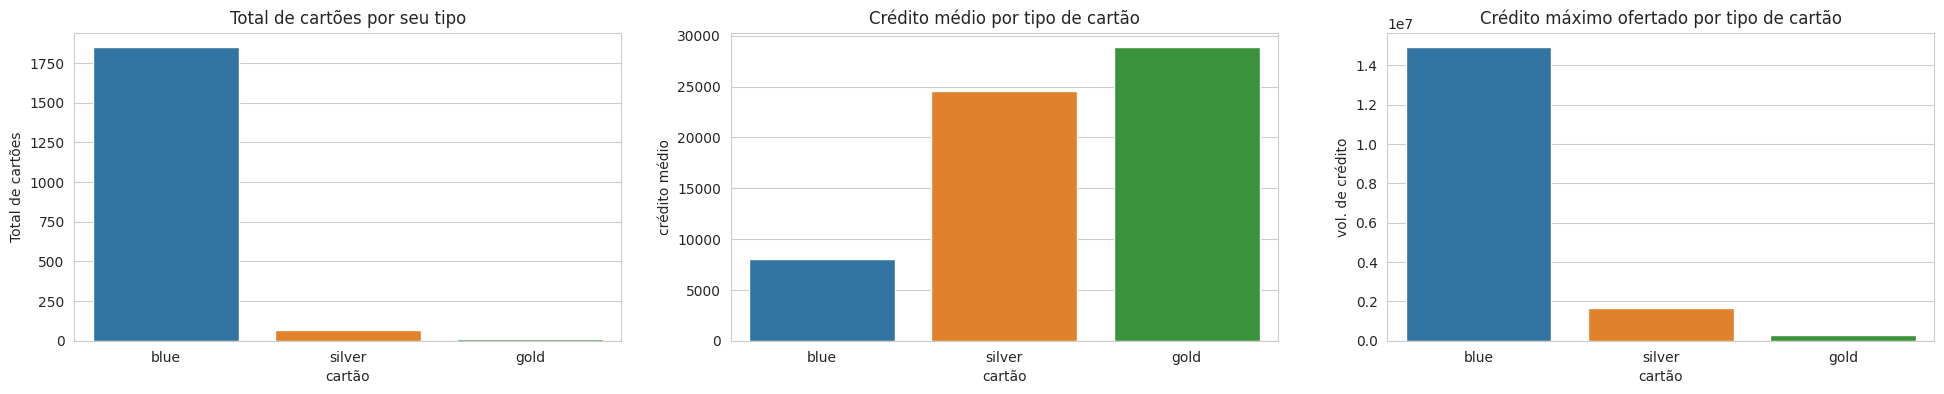

In [355]:
with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(1, 3, figsize=(8*3,4))

  sns.barplot(Q14, x='tipo_cartao', y='qtd_grupo', ax=ax[0])
  ax[0].set_title('Total de cartões por seu tipo')
  ax[0].set_xlabel('cartão')
  ax[0].set_ylabel('Total de cartões')

  sns.barplot(Q14, x='tipo_cartao', y='media_credito', ax=ax[1])
  ax[1].set_title('Crédito médio por tipo de cartão')
  ax[1].set_xlabel('cartão')
  ax[1].set_ylabel('crédito médio')

  sns.barplot(Q14, x='tipo_cartao', y='credito_ofertado', ax=ax[2])
  ax[2].set_title('Crédito máximo ofertado por tipo de cartão')
  ax[2].set_xlabel('cartão')
  ax[2].set_ylabel('vol. de crédito')

In [356]:
Q15 = sqldf('''
select 
  tipo_cartao
, salario_anual
, count(*) as qtd_grupo
, round(avg(limite_credito),2) as media_credito
, round(sum(limite_credito),2) as credito_ofertado
from credito 
group by tipo_cartao, salario_anual
order by case when tipo_cartao = 'blue'   then 1
              when tipo_cartao = 'silver' then 2
              else 3 end
       , case when salario_anual = 'menos que $40K' then 1
              when salario_anual = '$40K - $60K'    then 2
              when salario_anual = '$60K - $80K'    then 3
              when salario_anual = '$80K - $120K'   then 4
              else 5 end
''')
Q15

,tipo_cartao,salario_anual,qtd_grupo,media_credito,credito_ofertado
0,blue,menos que $40K,577,3811.79,2199402.95
1,blue,$40K - $60K,371,4708.75,1746945.91
2,blue,$60K - $80K,349,8002.26,2792788.42
3,blue,$80K - $120K,377,13923.74,5249248.24
4,blue,$120K +,174,16765.65,2917222.67
5,silver,menos que $40K,17,11743.41,199637.93
6,silver,$40K - $60K,14,17638.20,246934.76
7,silver,$60K - $80K,10,31403.56,314035.60
8,silver,$80K - $120K,20,34516.39,690327.81
9,silver,$120K +,7,31719.54,222036.77


<p align='justify'>O cartão blue é tão mais usado frente aos demais cartões que era de se esperar que, independente de renda anual, haveria clientes de diferentes classes sociais ou faixa salarial em grande quantidade.

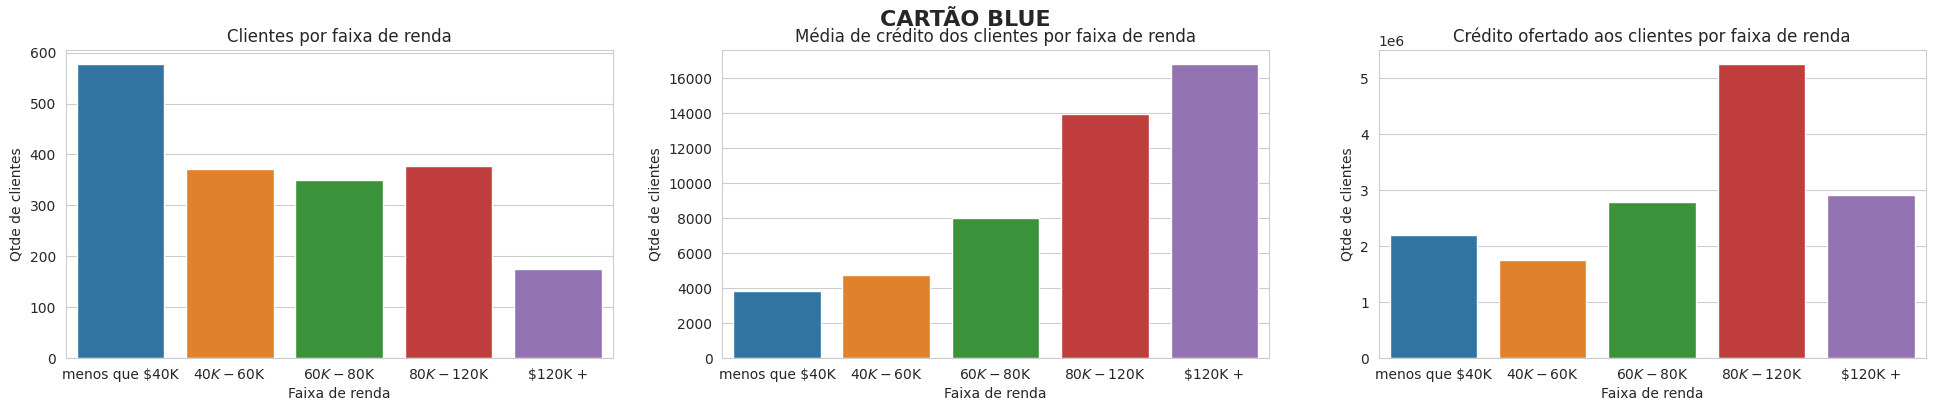

In [357]:
with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(1, 3, figsize=(8*3,4))
  
  fig.suptitle('CARTÃO BLUE', fontweight='bold', fontsize=16)
  sns.barplot(Q15.query('tipo_cartao=="blue"'), x='salario_anual', y='qtd_grupo', ax=ax[0])
  ax[0].set_title('Clientes por faixa de renda')
  ax[0].set_xlabel('Faixa de renda')
  ax[0].set_ylabel('Qtde de clientes')

  sns.barplot(Q15.query('tipo_cartao=="blue"'), x='salario_anual', y='media_credito', ax=ax[1])
  ax[1].set_title('Média de crédito dos clientes por faixa de renda')
  ax[1].set_xlabel('Faixa de renda')
  ax[1].set_ylabel('Qtde de clientes')

  sns.barplot(Q15.query('tipo_cartao=="blue"'), x='salario_anual', y='credito_ofertado', ax=ax[2])
  ax[2].set_title('Crédito ofertado aos clientes por faixa de renda')
  ax[2].set_xlabel('Faixa de renda')
  ax[2].set_ylabel('Qtde de clientes')

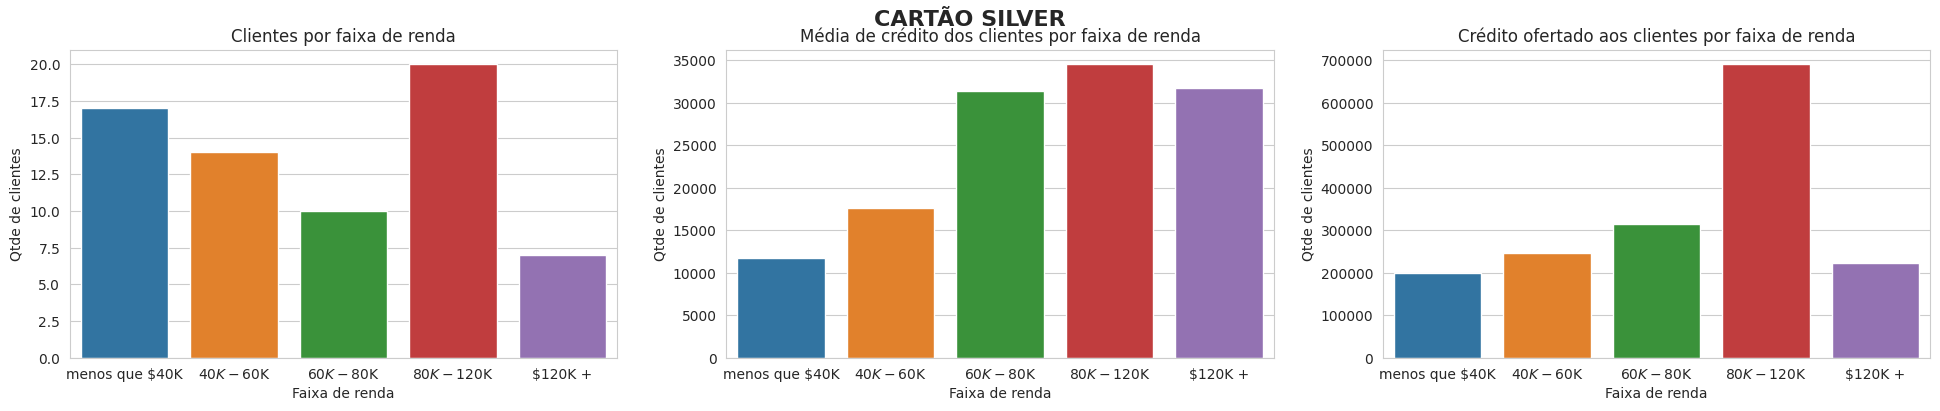

In [358]:
with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(1, 3, figsize=(8*3,4))
  
  fig.suptitle('CARTÃO SILVER', fontweight='bold', fontsize=16)
  sns.barplot(Q15.query('tipo_cartao=="silver"'), x='salario_anual', y='qtd_grupo', ax=ax[0])
  ax[0].set_title('Clientes por faixa de renda')
  ax[0].set_xlabel('Faixa de renda')
  ax[0].set_ylabel('Qtde de clientes')

  sns.barplot(Q15.query('tipo_cartao=="silver"'), x='salario_anual', y='media_credito', ax=ax[1])
  ax[1].set_title('Média de crédito dos clientes por faixa de renda')
  ax[1].set_xlabel('Faixa de renda')
  ax[1].set_ylabel('Qtde de clientes')

  sns.barplot(Q15.query('tipo_cartao=="silver"'), x='salario_anual', y='credito_ofertado', ax=ax[2])
  ax[2].set_title('Crédito ofertado aos clientes por faixa de renda')
  ax[2].set_xlabel('Faixa de renda')
  ax[2].set_ylabel('Qtde de clientes')

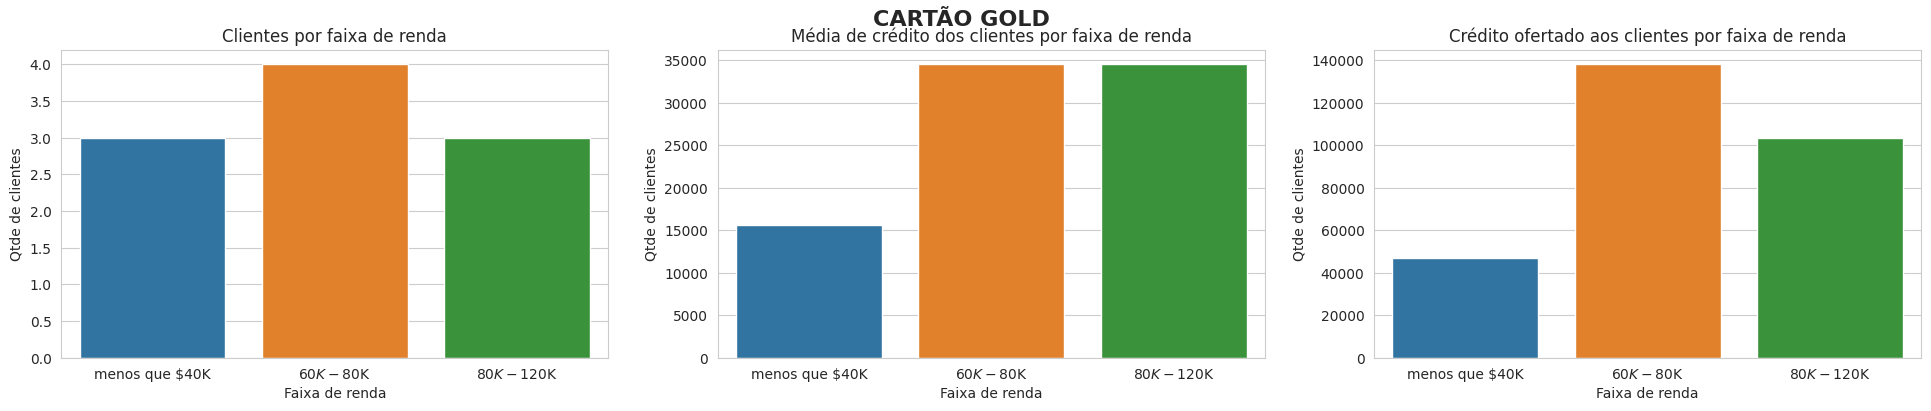

In [359]:
with sns.axes_style("whitegrid"):
  fig, ax = plt.subplots(1, 3, figsize=(8*3,4))
  
  fig.suptitle('CARTÃO GOLD', fontweight='bold', fontsize=16)
  sns.barplot(Q15.query('tipo_cartao=="gold"'), x='salario_anual', y='qtd_grupo', ax=ax[0])
  ax[0].set_title('Clientes por faixa de renda')
  ax[0].set_xlabel('Faixa de renda')
  ax[0].set_ylabel('Qtde de clientes')

  sns.barplot(Q15.query('tipo_cartao=="gold"'), x='salario_anual', y='media_credito', ax=ax[1])
  ax[1].set_title('Média de crédito dos clientes por faixa de renda')
  ax[1].set_xlabel('Faixa de renda')
  ax[1].set_ylabel('Qtde de clientes')

  sns.barplot(Q15.query('tipo_cartao=="gold"'), x='salario_anual', y='credito_ofertado', ax=ax[2])
  ax[2].set_title('Crédito ofertado aos clientes por faixa de renda')
  ax[2].set_xlabel('Faixa de renda')
  ax[2].set_ylabel('Qtde de clientes')

### 4.3. Análise de crédito por sexo e tipo de cartão

In [360]:
Q16 = sqldf('''
select 
  a.*
, round(100*credito_ofertado / sum(credito_ofertado) over(),2) as cred_ofert_perc from (
select 
  tipo_cartao
, sexo
, count(*) as qtd_grupo
, round(avg(limite_credito),2) as media_credito
, round(sum(limite_credito),2) as credito_ofertado
from credito 
group by tipo_cartao, sexo
order by credito_ofertado desc) as a
''')
Q16

,tipo_cartao,sexo,qtd_grupo,media_credito,credito_ofertado,cred_ofert_perc
0,blue,M,1202,10238.09,12306180.70,72.96
1,blue,F,646,4023.88,2599427.49,15.41
2,silver,M,48,29460.28,1414093.37,8.38
3,silver,F,20,12943.98,258879.50,1.53
4,gold,M,7,34516.78,241617.45,1.43
5,gold,F,3,15651.99,46955.98,0.28


<p align='justify'>Apesar do peso dos homens, mulheres acabam tendo bastante peso por quase todas possuírem um cartão blue. Homens deste mesmo cartão ainda assim recebem de limite de crédito quase 73% de todo o crédito ofertado. Ambos juntos detêm 88,37% de todo o crédito dado pelo banco.

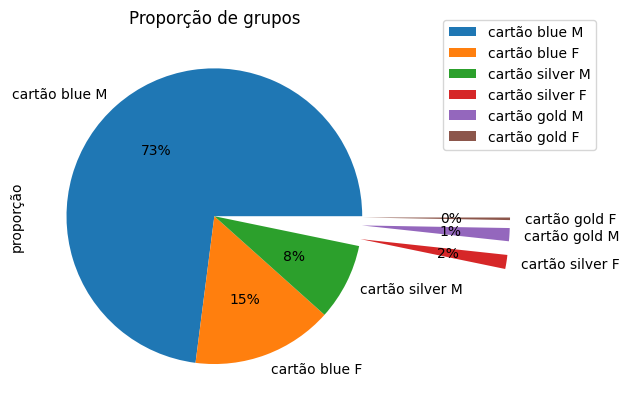

In [361]:
q = sqldf('''select 'cartão ' || tipo_cartao || ' ' || sexo as grupo, cred_ofert_perc as proporção from Q16''')
ax = q.plot.pie(y='proporção', 
                title='Proporção de grupos', 
                autopct='%.0f%%', 
                labels=q.grupo, 
                explode=[0,0,0,1,1,1])

ax.legend(bbox_to_anchor=(1.1, 1.05), loc='upper left');

### 4.4. Análise de crédito por dependentes e renda

In [362]:
Q17 = sqldf('''
select 
  dependentes
, round(avg(valor_transacoes_12m),2)                      as avg_transacao
, round(sum(valor_transacoes_12m) / sum(qtd_produtos),2)  as 'preco/produto'
, round(avg(limite_credito),2)                            as media_credito
from credito 
group by dependentes
''')
Q17

,dependentes,avg_transacao,preco/produto,media_credito
0,0,1890.31,433.45,5087.33
1,1,1845.73,423.63,7997.90
2,2,1790.25,417.62,8948.36
3,3,1800.98,414.65,9798.79
4,4,1793.35,405.68,11056.89
5,5,1608.37,384.22,11430.64


<p align='justify'>Para quanto mais dependentes, a média de crédito é maior. Como já visto anteriormente, quanto maior a renda, maior a média de dependentes (3.10.), e quanto maior a renda, menor a média transacionada e o preço médio dos produtos (4.1.).

In [363]:
sqldf('''
select a.salario_anual, a.media_credito, a.avg_transacao, a.'preco/produto', b.avg_dependentes from
(select
  salario_anual
, round(avg(valor_transacoes_12m),2)                     as avg_transacao
, round(avg(limite_credito),2)                           as media_credito
, round(sum(valor_transacoes_12m) / sum(qtd_produtos),2) as 'preco/produto'
from credito
group by salario_anual) a

inner join

(select
    salario_anual
  , round(avg(dependentes),1) as avg_dependentes
  from credito
  group by salario_anual) b

on a.salario_anual = b.salario_anual
order by case when a.salario_anual = 'menos que $40K' then 1
              when a.salario_anual = '$40K - $60K'    then 2
              when a.salario_anual = '$60K - $80K'    then 3
              when a.salario_anual = '$80K - $120K'   then 4
              else 5 end
''')

,salario_anual,media_credito,avg_transacao,preco/produto,avg_dependentes
0,menos que $40K,4097.15,1856.01,423.24,1.9
1,$40K - $60K,5178.91,1840.97,423.15,1.9
2,$60K - $80K,8939.09,1807.17,415.72,2.2
3,$80K - $120K,15107.82,1780.08,414.70,2.3
4,$120K +,17343.97,1707.06,401.79,2.4


## 5. Conclusões

<p align='justify'>Pela análise demográfica, clientes do gênero masculino são os mais relevantes e com maiores salários. São bem instruídos muito por conta da boa maioria possuir um mestrado, e boa parte ganha mais de 80mil por ano. Já mulheres ganham menos mesmo com boa formação.

<p align='justify'>Renda anual, dependentes e gastos parecem conversar. Quanto maior a renda, maior o limite de crédito (nada inesperado). Mas, a média de dependentes tende a subir com a renda, fazendo com que as pessoas gastem um pouco menos e em produtos, a princípio, mais baratos. 

<p align='justify'>Como homens têm a maior renda, estes são os com maior crédito e os que gastam menos em média para maiores salários.

<p align='justify'>Homens são um cliente importante pelo poder de compra e volume. Mas mulheres também o são, mas de um segmento diferente. Elas ganham menos tem menos crédito, dominantes na faixa salarial de até $40.000$. O cartão blue é especialmente usado por este grupo, o qual é o cartão com menor limite de crédito. Mas, que por ser o mais utilizado, possui o maior volume de crédito ofertado ($14.905.608,19$).